# Predictive Insights & Cross-Dataset Correlation

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import seaborn as sns

import time
import os

import math
import scipy.stats as stats

In [55]:
enrolment = pd.read_csv('Featured Datasets/featured_enrolment.csv')
biometric = pd.read_csv('Featured Datasets/featured_biometric.csv')
demography = pd.read_csv('Featured Datasets/featured_demographic.csv')

os.makedirs('System Analyses', exist_ok=True)
print("Successfully loaded the Cleaned Datasets")

Successfully loaded the Cleaned Datasets


In [56]:
print(enrolment.info())
print('-'*50)
print(demography.info())
print('-'*50)
print(biometric.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006007 entries, 0 to 1006006
Data columns (total 20 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   date                     1006007 non-null  object 
 1   state                    1006007 non-null  object 
 2   district                 1006007 non-null  object 
 3   pincode                  1006007 non-null  int64  
 4   age_0_5                  1006007 non-null  int64  
 5   age_5_17                 1006007 non-null  int64  
 6   age_18+                  1006007 non-null  int64  
 7   total_enrolment          1006007 non-null  int64  
 8   day                      1006007 non-null  int64  
 9   month                    1006007 non-null  int64  
 10  day_name                 1006007 non-null  object 
 11  is_weekend               1006007 non-null  int64  
 12  region                   1006007 non-null  object 
 13  quarter                  1006007 non-null 

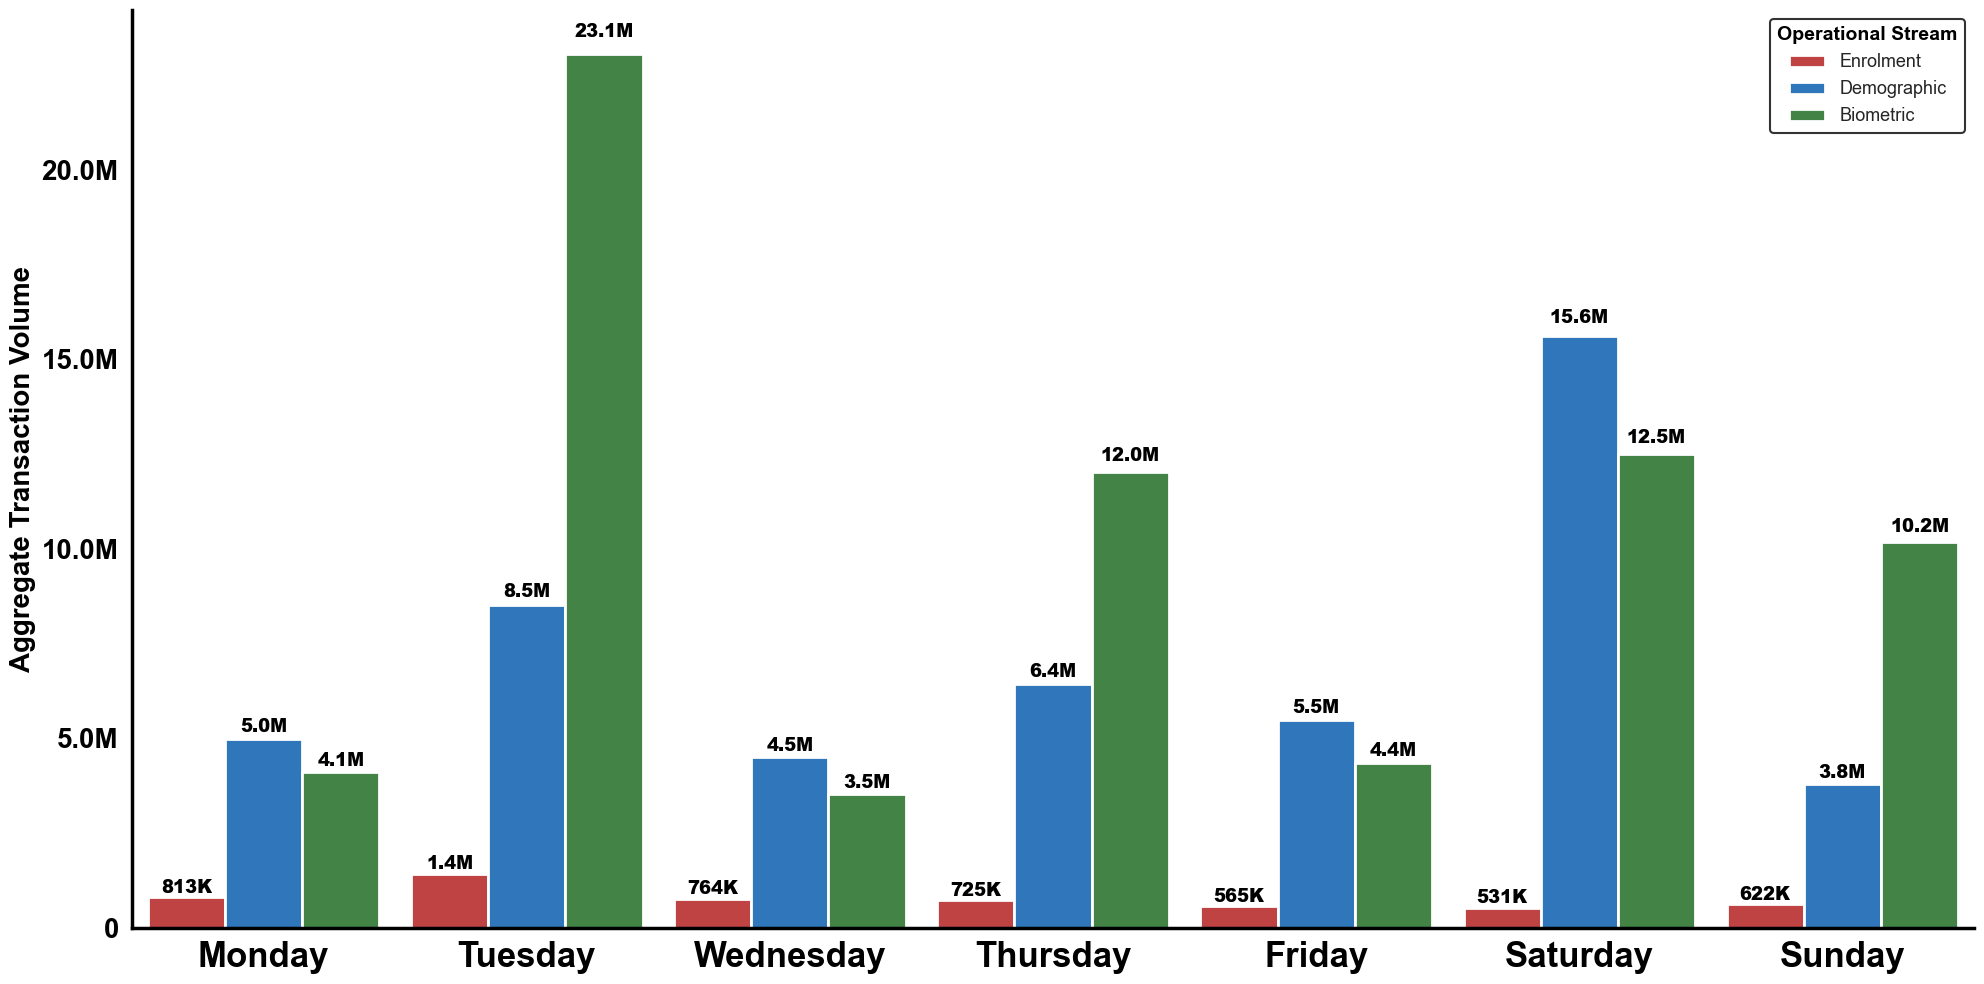

In [57]:
# --- 1. Aggregation Logic (Unchanged) ---
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def get_stats(df, col, label):
    s = df.groupby('day_name')[col].sum().reindex(day_order)
    return pd.DataFrame({'Day': day_order, 'Total': s.values, 'Stream': label})

master = pd.concat([
    get_stats(enrolment, 'total_enrolment', 'Enrolment'),
    get_stats(demography, 'total_updates', 'Demographic'),
    get_stats(biometric, 'total_biometric', 'Biometric')
])

# --- 2. High-Contrast Visualization ---
plt.figure(figsize=(20, 10))
sns.set_style("white")

# Darker shades of Aadhaar brand colors for maximum contrast
colors = {'Enrolment': '#D32F2F', 'Demographic': '#1976D2', 'Biometric': '#388E3C'}

# Wide bars with thick white edges to separate them from the background
ax = sns.barplot(data=master, x='Day', y='Total', hue='Stream', 
                 palette=colors, width=0.88, edgecolor='white', linewidth=2)

# --- 3. Custom Formatting for Darker Axes & Text ---
def fmt(x):
    if x >= 1e6: return f'{x/1e6:.1f}M'
    if x >= 1e3: return f'{x/1e3:.0f}K'
    return str(int(x))

# A. Darken and Bold the Top Labels
for p in ax.patches:
    val = p.get_height()
    if val > 0:
        ax.text(p.get_x() + p.get_width()/2, val + (val * 0.015), 
                fmt(val), ha='center', va='bottom', 
                fontweight='black', size=13, color='#000000') # Absolute Black

# B. Darken and Thicken the Rows and Columns (Axes)
#plt.title('Aadhaar System Bottleneck: The Monday-Tuesday Operational Surge', 
#          fontsize=24, fontweight='black', loc='left', pad=40, color='#000000')

plt.ylabel('Aggregate Transaction Volume', fontsize=20, fontweight='bold', color='#000000')
plt.xlabel('')

# Darken X and Y tick labels
plt.xticks(fontsize=25, fontweight='bold', color='#000000')
plt.yticks(fontsize=20, fontweight='bold', color='#000000')

# C. Make the actual axis lines (Spines) thicker and darker
for spine in ax.spines.values():
    spine.set_edgecolor('#000000') # Set to pure black
    spine.set_linewidth(2.5)       # Increase thickness significantly

# Remove unnecessary background grid/lines but keep the bottom spine for grounding
ax.grid(False)
sns.despine(left=False, top=True, right=True) # Keep left and bottom lines

# D. Professional Legend
leg = plt.legend(title='Operational Stream', frameon=True, loc='upper right', fontsize=13)
plt.setp(leg.get_title(), fontweight='bold', fontsize=14, color='#000000')
leg.get_frame().set_edgecolor('#000000') # Border for the legend
leg.get_frame().set_linewidth(1.5)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: fmt(x)))

plt.tight_layout()
plt.savefig('System Analyses/Day_wise_activity_distribution.png', dpi=300)
plt.show()

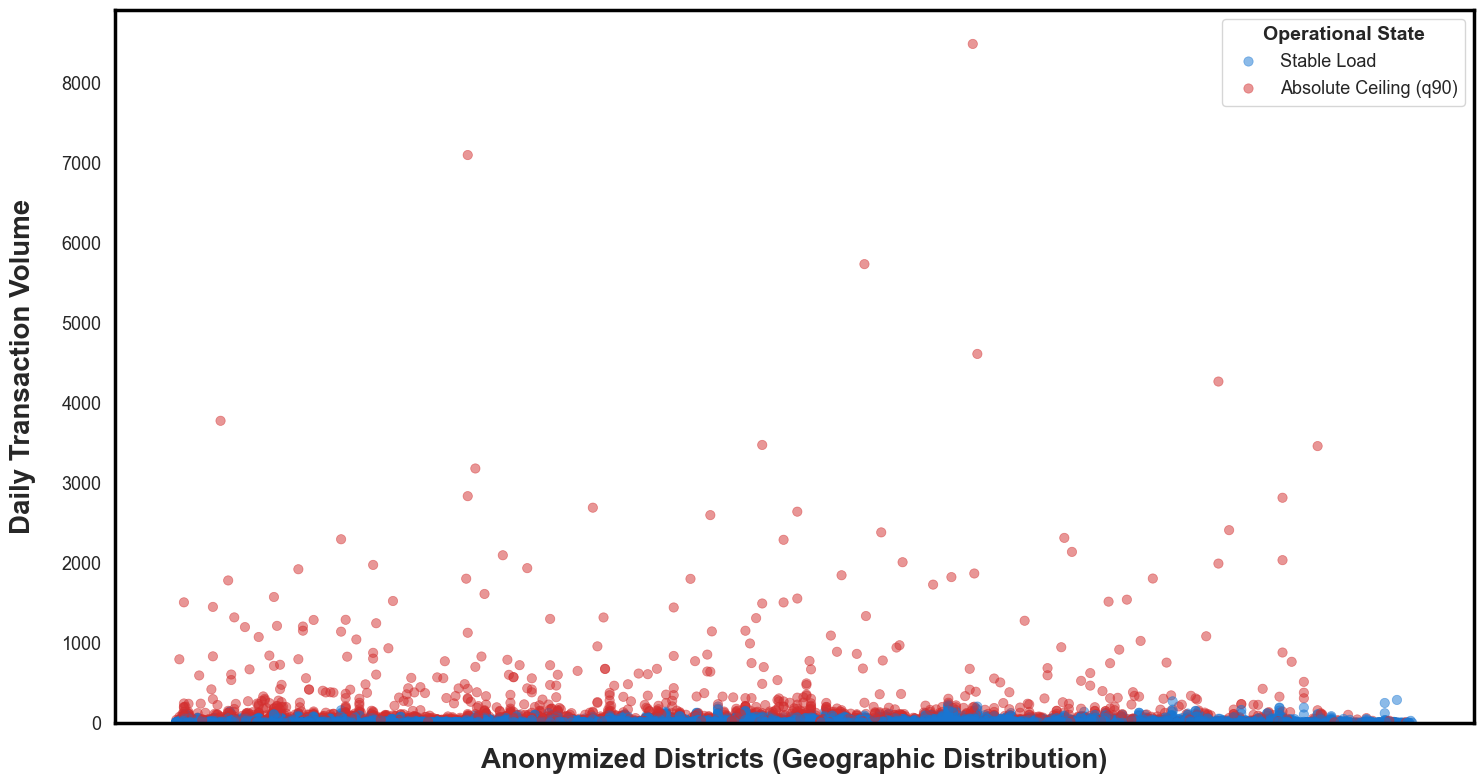

In [102]:
# Create directory
os.makedirs('System Analyses', exist_ok=True)

plt.figure(figsize=(15, 8))
sns.set_style("white")

# Palette: Blue for Standard Load, Red for Absolute Ceiling (High Intensity)
colors = {0: '#1976D2', 1: '#D32F2F'} 

# Sample for visual stability (using demography stream)
df_plot = demography.sample(n=min(25000, len(demography)), random_state=42)

ax = sns.scatterplot(
    data=df_plot, 
    x='district', 
    y='total_updates',
    hue='is_high_intensity', 
    palette=colors,
    alpha=0.5,
    s=45,
    edgecolor=None
)

# --- Grounding Y-axis at 0 ---
plt.ylim(0, df_plot['total_updates'].max() * 1.05)

# --- UPDATED: Increased Font Sizes for Axis Attributes ---
plt.ylabel('Daily Transaction Volume', fontsize=20, fontweight='bold', labelpad=18)
plt.xlabel('Anonymized Districts (Geographic Distribution)', fontsize=20, fontweight='bold', labelpad=18)

# Increase tick label size (specifically for Y-axis as X-axis is hidden)
plt.yticks(fontsize=13)
plt.xticks([]) # Keeping districts hidden for clean visual distribution

# --- Fix: Explicit Legend Colors & Increased Font ---
handles, _ = ax.get_legend_handles_labels()
leg = ax.legend(
    handles=handles, 
    labels=['Stable Load', 'Absolute Ceiling (q90)'],
    title='Operational State', 
    frameon=True, 
    fontsize=13, # Increased
    loc='upper right'
)
plt.setp(leg.get_title(), fontweight='bold', fontsize=14)

# Styling: Thickened spines for professional PDF clarity
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)

# plt.title('Spatial Stress: Identifying Local Infrastructure Saturation', fontsize=22, fontweight='black', pad=30)

plt.tight_layout()
plt.savefig('System Analyses/Spatial_Stress_Saturation.png', dpi=300)
plt.show()

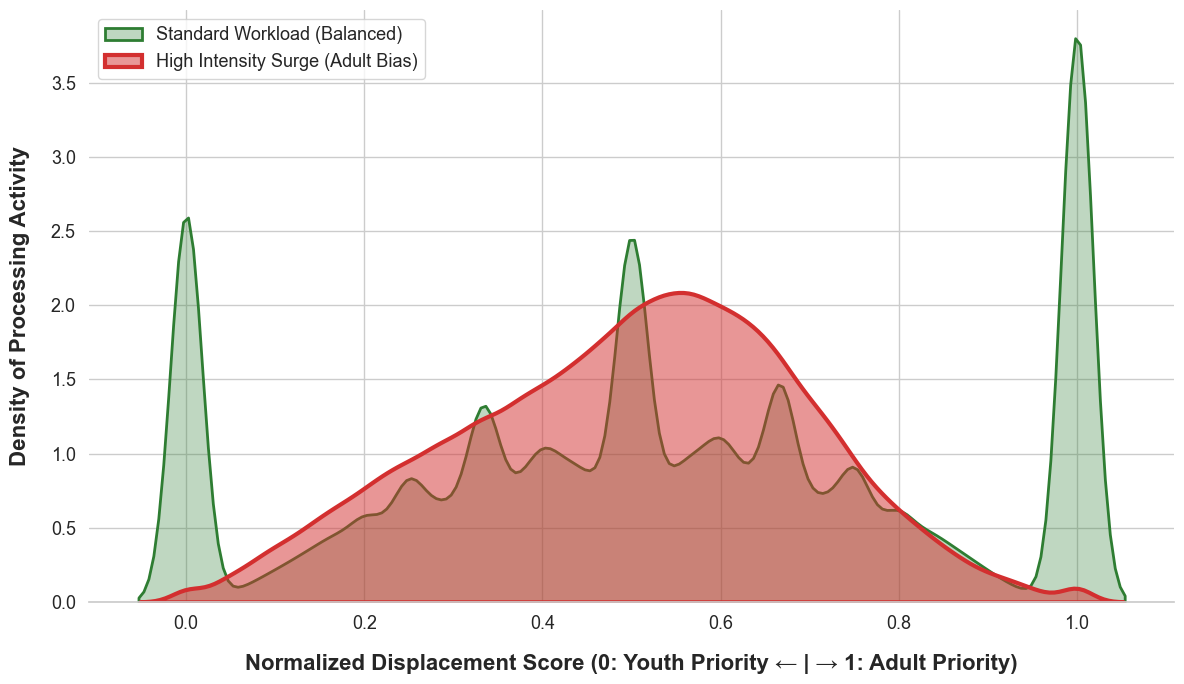

In [96]:
# Ensure directory exists
os.makedirs('System Analyses', exist_ok=True)

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Normalized Displacement Score: Higher = more Adult-centric
sns.kdeplot(
    data=biometric[biometric['is_high_intensity'] == 0], 
    x='displacement_score_norm', 
    label='Standard Workload (Balanced)', 
    fill=True, color='#2E7D32', alpha=0.3, linewidth=2
)

sns.kdeplot(
    data=biometric[biometric['is_high_intensity'] == 1], 
    x='displacement_score_norm', 
    label='High Intensity Surge (Adult Bias)', 
    fill=True, color='#D32F2F', alpha=0.5, linewidth=3
)

# --- UPDATED: Increased Font Sizes for Axis Attributes ---
plt.xlabel('Normalized Displacement Score (0: Youth Priority ← | → 1: Adult Priority)', 
           fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Density of Processing Activity', 
           fontsize=16, fontweight='bold', labelpad=15)

# Increase tick label size for better readability
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Professional Legend Styling
plt.legend(frameon=True, fontsize=13, loc='upper left')

sns.despine(left=True)
plt.tight_layout()

# Save the updated high-resolution figure
plt.savefig('System Analyses/Displacement_Bias_Trend.png', dpi=300)
plt.show()